In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier


In [86]:


# get the features from the file features.txt
features = list()
with open('UCI HAR Dataset/features.txt') as f:
    features = [line.split()[1] for line in f.readlines()]
print('No of Features: {}'.format(len(features)))

No of Features: 561


In [116]:
#Getting the train data

# Read feature data
X_train = pd.read_csv('UCI HAR Dataset/train/X_train.txt', delim_whitespace=True, header=None)

# Assign column names directly
X_train.columns = [f'feature_{i}' for i in range(1, len(X_train.columns) + 1)]

# Read subject data and add as a new column
subject_train = pd.read_csv('UCI HAR Dataset/train/subject_train.txt', header=None)
X_train['subject'] = subject_train

# Read activity labels data and add as a new column
y_train = pd.read_csv('UCI HAR Dataset/train/y_train.txt', names=['Activity'])
y_train_labels = y_train['Activity'].map({1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'})
train = X_train
X_train['Activity'] = y_train['Activity']
X_train['ActivityName'] = y_train_labels

# Display a sample of the DataFrame
print(X_train.sample(2))

      feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
271    0.398249   0.027318  -0.062956  -0.285904   0.162323  -0.211032   
7093   0.248950  -0.017052  -0.065224  -0.393014  -0.167416  -0.138050   

      feature_7  feature_8  feature_9  feature_10  ...  feature_555  \
271   -0.346634   0.075400  -0.173744   -0.066366  ...    -0.247038   
7093  -0.442736  -0.170758  -0.151450   -0.219108  ...     0.273612   

      feature_556  feature_557  feature_558  feature_559  feature_560  \
271     -0.525320     0.677174    -0.105358    -0.656642     0.317010   
7093    -0.505894    -0.712965    -0.557902    -0.853741     0.197415   

      feature_561  subject  Activity  ActivityName  
271      0.110095        1         1       WALKING  
7093     0.037992       30         1       WALKING  

[2 rows x 564 columns]


In [139]:
train.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_554,feature_555,feature_556,feature_557,feature_558,feature_559,feature_560,feature_561,subject,Activity
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515,17.413085,3.643362
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122,8.975143,1.744802
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414,8.000000,2.000000
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181,19.000000,4.000000
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659,26.000000,5.000000
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000,30.000000,6.000000


In [117]:
#Getting the test

# Read feature data
X_test = pd.read_csv('UCI HAR Dataset/test/X_test.txt', delim_whitespace=True, header=None)

# Assign column names directly
X_test.columns = [f'feature_{i}' for i in range(1, len(X_test.columns) + 1)]

# Read subject data and add as a new column
X_test['subject'] = pd.read_csv('UCI HAR Dataset/test/subject_test.txt', header=None)

# Read activity labels data and add as a new column
y_test = pd.read_csv('UCI HAR Dataset/test/y_test.txt', names=['Activity'])
y_test_labels = y_test['Activity'].map({1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'})
X_test['Activity'] = y_test['Activity']
X_test['ActivityName'] = y_test_labels
test = X_test

# Display a sample of the DataFrame
print(X_test.sample(2))

      feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
2492   0.278506  -0.016924  -0.112603  -0.995273  -0.990172  -0.986872   
2606   0.273674  -0.011832  -0.106453  -0.994595  -0.977696  -0.988199   

      feature_7  feature_8  feature_9  feature_10  ...  feature_555  \
2492  -0.996631  -0.989720  -0.985903   -0.932200  ...      0.09958   
2606  -0.994548  -0.976149  -0.986808   -0.942286  ...     -0.01346   

      feature_556  feature_557  feature_558  feature_559  feature_560  \
2492    -0.237066     0.585004     0.489430     0.622565    -0.848147   
2606     0.068363     0.075242     0.493119    -0.675941    -0.095987   

      feature_561  subject  Activity  ActivityName  
2492    -0.143780       20         6        LAYING  
2606    -0.101988       24         4       SITTING  

[2 rows x 564 columns]


In [140]:
test.describe()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_554,feature_555,feature_556,feature_557,feature_558,feature_559,feature_560,feature_561,subject,Activity
count,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,...,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000
mean,0.273996,-0.017863,-0.108386,-0.613635,-0.508330,-0.633797,-0.641278,-0.522676,-0.637038,-0.462063,...,-0.598756,0.005264,0.003799,0.040029,-0.017298,-0.513923,0.074886,-0.048720,12.986427,3.577876
std,0.060570,0.025745,0.042747,0.412597,0.494269,0.362699,0.385199,0.479899,0.357753,0.523916,...,0.311042,0.336147,0.445077,0.634989,0.501311,0.509205,0.324300,0.241467,6.950984,1.740348
min,-0.592004,-0.362884,-0.576184,-0.999606,-1.000000,-0.998955,-0.999417,-0.999914,-0.998899,-0.952357,...,-1.000000,-1.000000,-0.993402,-0.998898,-0.991096,-0.984195,-0.913704,-0.949228,2.000000,1.000000
25%,0.262075,-0.024961,-0.121162,-0.990914,-0.973664,-0.976122,-0.992333,-0.974131,-0.975352,-0.934447,...,-0.829593,-0.130541,-0.282600,-0.518924,-0.428375,-0.829722,0.022140,-0.098485,9.000000,2.000000
50%,0.277113,-0.016967,-0.108458,-0.931214,-0.790972,-0.827534,-0.937664,-0.799907,-0.817005,-0.852659,...,-0.683672,0.005188,0.006767,0.047113,-0.026726,-0.729648,0.181563,-0.010671,12.000000,4.000000
75%,0.288097,-0.010143,-0.097123,-0.267395,-0.105919,-0.311432,-0.321719,-0.133488,-0.322771,-0.009965,...,-0.458332,0.146200,0.288113,0.622151,0.394387,-0.545939,0.260252,0.092373,18.000000,5.000000
max,0.671887,0.246106,0.494114,0.465299,1.000000,0.489703,0.439657,1.000000,0.427958,0.786436,...,1.000000,0.998898,0.986347,1.000000,1.000000,0.833180,1.000000,0.973113,24.000000,6.000000


In [118]:
# Define the list of activity labels
labels=['LAYING', 'SITTING','STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']


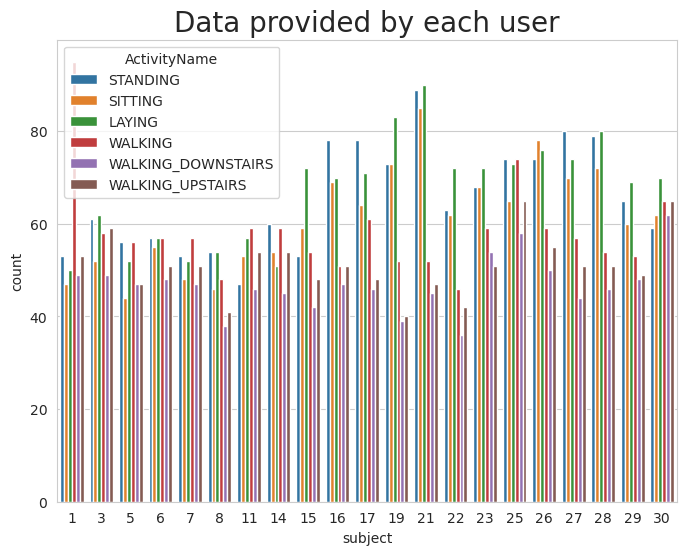

In [119]:
plt.figure(figsize=(8,6))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x='subject',hue='ActivityName', data = train)
plt.show()

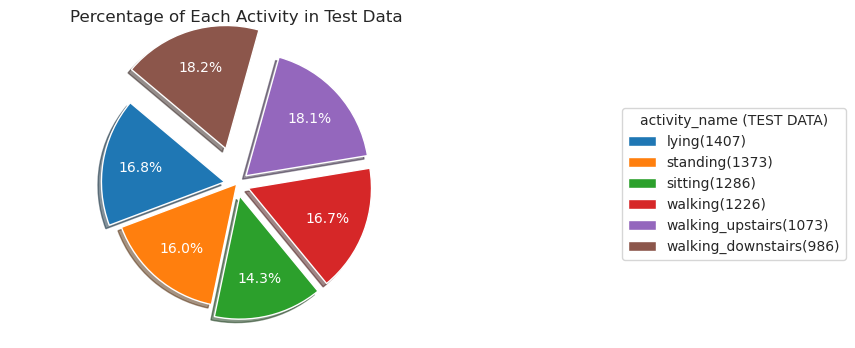

In [120]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
data = {
    'ActivityName': ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING'],
    'Count': [test['ActivityName'].value_counts()[activity] for activity in ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']]
}

# Convert data to DataFrame
activity_df = pd.DataFrame(data)

# Plot pie chart
plt.figure(figsize=(4,4))
plt.pie(activity_df['Count'], labels=activity_df['ActivityName'], autopct='%1.1f%%',pctdistance=0.69, textprops=dict(color="w"),
        shadow=True,explode=(0.1,0.0,0.1,0.1,0.1,0.3), startangle=140)
#adding legend
plt.legend(type,
          title="activity_name (TEST DATA)",
          loc="right", bbox_to_anchor=(2, 0, 0.5, 1))
plt.title('Percentage of Each Activity in Test Data')
plt.show()


/Users/ashikamohanm/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


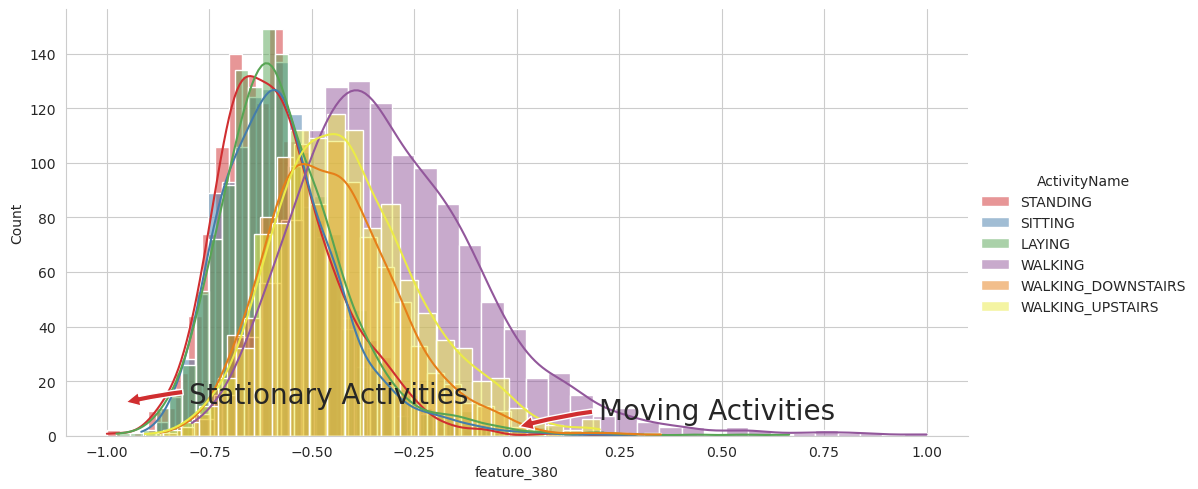

In [135]:
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Randomly select a feature from the dataset
random_feature = random.choice(train.columns[:-3])  

# Set color palette
sns.set_palette("Set1", desat=0.80)

# Create a FacetGrid
facetgrid = sns.FacetGrid(train, hue='ActivityName', height=5, aspect=2)

# Map a distribution plot for the random feature with legend
facetgrid.map(sns.histplot, random_feature, kde=True).add_legend()

# Annotate "Stationary Activities"
plt.annotate("Stationary Activities", xy=(-0.960, 12), xytext=(-0.8, 15), size=20, \
             va='center', ha='left', \
             arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=0.1"))

# Annotate "Moving Activities"
plt.annotate("Moving Activities", xy=(0, 3), xytext=(0.2, 9), size=20, \
             va='center', ha='left', \
             arrowprops=dict(arrowstyle="simple", connectionstyle="arc3,rad=0.1"))

# Show the plot
plt.show()


X_train and y_train: ((7352, 561), (7352,))
X_test and y_test: ((2947, 561), (2947,))
Original Shape of Scaled Training Data: (7352, 561)
Shape of Transformed Training Data after PCA: (7352, 200)
Original Shape of Scaled Testing Data: (2947, 561)
Shape of Transformed Testing Data after PCA: (2947, 200)


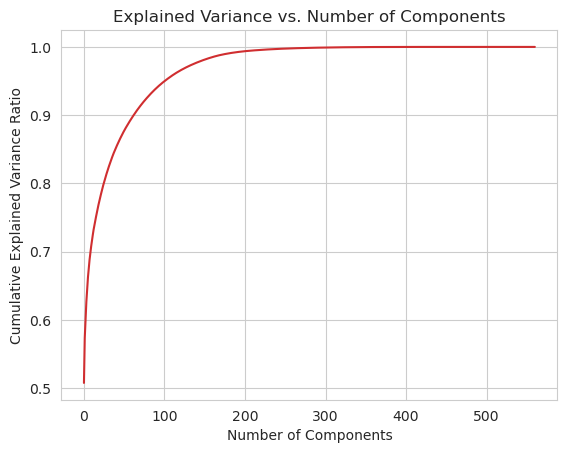

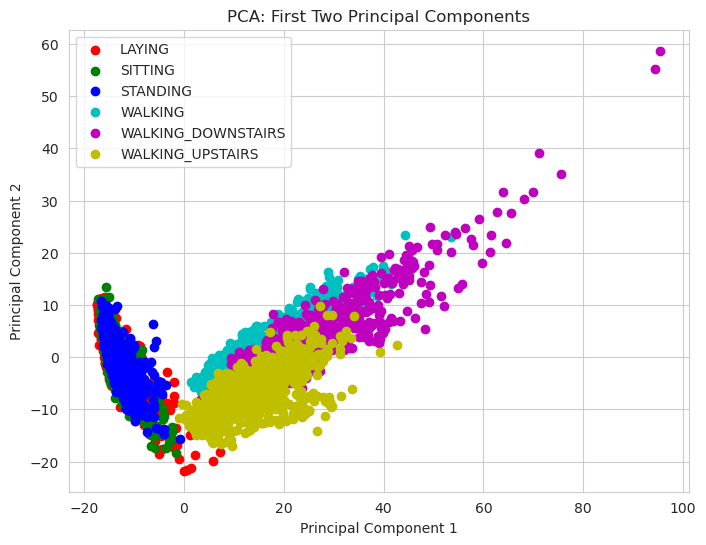

In [141]:
# Outlier Detection and Removal
def remove_outliers(X_train, y_train, contamination=0.1):
    clf = IsolationForest(contamination=contamination, random_state=42)
    y_outliers = clf.fit_predict(X_train)
    X_train_clean = X_train[y_outliers == 1]
    y_train_clean = y_train[y_outliers == 1]
    return X_train_clean, y_train_clean

# Feature Scaling
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# Feature Selection
def select_features(X_train, y_train, X_test, k=10):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    return X_train_selected, X_test_selected

# Dimensionality Reduction
def reduce_dimensionality(X_train, X_test, n_components=10):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca


# Split train data into features (X_train) and labels (y_train)
X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train['ActivityName']

# Split test data into features (X_test) and labels (y_test)
X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test['ActivityName']

# Print shapes of the datasets
print('X_train and y_train: ({}, {})'.format(X_train.shape, y_train.shape))
print('X_test and y_test: ({}, {})'.format(X_test.shape, y_test.shape))


scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(X_train)
scaled_test_data = scaler.transform(X_test)

# Perform Principle Component Analysis (PCA)
n_components = 200
pca = PCA(n_components=n_components)
pca.fit(scaled_train_data)

# Apply PCA transformation to both training and test data
x_train_pca = pca.transform(scaled_train_data)
x_test_pca = pca.transform(scaled_test_data)

# Print shapes of the original and transformed data
print('Original Shape of Scaled Training Data:', scaled_train_data.shape)
print('Shape of Transformed Training Data after PCA:', x_train_pca.shape)
print('Original Shape of Scaled Testing Data:', scaled_test_data.shape)
print('Shape of Transformed Testing Data after PCA:', x_test_pca.shape)

# Handle Categorical Variables
label_encoder = LabelEncoder()
X_train['Activity'] = y_train
X_test['Activity'] = y_test

# Encode Activity column
X_train['Activity'] = label_encoder.fit_transform(X_train['Activity'])
X_test['Activity'] = label_encoder.transform(X_test['Activity'])



# Choosing the number of components
pca = PCA().fit(scaled_train_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs. Number of Components')
plt.show()

# Fit PCA on the scaled training data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(scaled_train_data)

# Plot the first two principal components
plt.figure(figsize=(8, 6))
colors = ['r', 'g', 'b', 'c', 'm', 'y']
for i, label in enumerate(labels):
    plt.scatter(X_train_pca[y_train == label, 0], X_train_pca[y_train == label, 1], c=colors[i], label=label)
plt.title('PCA: First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
#Data Preprocessing
#Finding number of duplicates 
print('No of duplicates in train: {}'.format(sum(train.duplicated())))
print('No of duplicates in test : {}'.format(sum(test.duplicated())))

No of duplicates in train: 0
No of duplicates in test : 0


In [29]:
#Finding number of null values 
print('We have {} NaN/Null values in train'.format(train.isnull().values.sum()))
print('We have {} NaN/Null values in test'.format(test.isnull().values.sum()))

We have 0 NaN/Null values in train
We have 0 NaN/Null values in test


In [30]:
#Converting this dataframe to csv file
train.to_csv('UCI HAR Dataset/train.csv', index=False)
test.to_csv('UCI HAR Dataset/test.csv', index=False)

In [31]:
#All the feature name with lots of unnecessary singhs: Changing feature names
columns = train.columns

# Removing '()' from column names
columns = columns.str.replace('[()]','')
columns = columns.str.replace('[-]', '')
columns = columns.str.replace('[,]','')

train.columns = columns
test.columns = columns

test.columns

Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10',
       ...
       'feature_555', 'feature_556', 'feature_557', 'feature_558',
       'feature_559', 'feature_560', 'feature_561', 'subject', 'Activity',
       'ActivityName'],
      dtype='object', length=564)

In [32]:
# Split train data into features (X_train) and labels (y_train)
X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train['ActivityName']

# Split test data into features (X_test) and labels (y_test)
X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test['ActivityName']

# Print shapes of the datasets
print('X_train and y_train: ({}, {})'.format(X_train.shape, y_train.shape))
print('X_test and y_test: ({}, {})'.format(X_test.shape, y_test.shape))

X_train and y_train: ((7352, 561), (7352,))
X_test and y_test: ((2947, 561), (2947,))


In [33]:
#Defining the function to plot the confusion matrix
plt.rcParams["font.family"] = 'DejaVu Sans'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (numpy array): The confusion matrix to be plotted.
        classes (list): A list of class labels.
        normalize (bool): If True, the confusion matrix will be normalized.
        title (str): The title of the plot.
        cmap (matplotlib colormap): The colormap used for the heatmap.

    Returns:
        None
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)

In [52]:
# making a function to run any model specified
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    """
    Train and evaluate a machine learning model, including calculating accuracy, confusion matrix,
    classification report, F1 score, and plotting the confusion matrix.

    Parameters:
        model: The machine learning model to be trained and evaluated.
        X_train: The feature matrix of the training data.
        y_train: The target labels of the training data.
        X_test: The feature matrix of the test data.
        y_test: The target labels of the test data.
        class_labels: A list of class labels for the confusion matrix.
        cm_normalize: Whether to normalize the confusion matrix (default is True).
        print_cm: Whether to print the confusion matrix (default is True).
        cm_cmap: The colormap used for the confusion matrix (default is plt.cm.Greens).

    Returns:
        results: A dictionary containing the evaluation results.
    """

    # Initialize dictionary to store results
    results = dict()
    
    # Record start time of training
    train_start_time = datetime.now()
    print('Training the model..')
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Record end time of training
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('==> Training time:', results['training_time'])
    
    y_pred_proba = model.predict_proba(X_test)
    # Predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    results['testing_time'] = test_end_time - test_start_time
    print('==> Testing time:', results['testing_time'])
    results['predicted'] = y_pred
   

    # Calculate overall accuracy of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    results['accuracy'] = accuracy
    print('==> Accuracy:', accuracy)

    # Calculate confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    
    # Print confusion matrix if requested
    if print_cm: 
        print('\n ******** Confusion Matrix ********')
        print('\n', cm)
   
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    plot_confusion_matrix(cm, classes=class_labels, normalize=cm_normalize, 
                          title='Normalized Confusion Matrix', cmap=cm_cmap)
    plt.show()

    # Generate classification report
    print('**************** Classification Report ****************')
    classification_report = metrics.classification_report(y_test, y_pred)
    results['classification_report'] = classification_report
    print(classification_report)

    # Store trained model in results
    results['model'] = model

    # Calculate F1 score
    f1_score = metrics.f1_score(y_test, y_pred, average='weighted')
    results['f1_score'] = f1_score
    print('\nF1 Score:', f1_score)

    # Calculate precision
    precision = precision_score(y_test, y_pred, average='weighted')
    results['precision'] = precision
    print('\nPrecision:', precision)
    
    # Calculate recall
    recall = recall_score(y_test, y_pred, average='weighted')
    results['recall'] = recall
    print('\nRecall:', recall)
    
    # Calculate ROC AUC using predicted probabilities
    roc_auc = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
    results['roc_auc'] = roc_auc
    print('\nROC AUC:', roc_auc)

    return results


In [54]:
# Making function to print the gridsearch Parameters
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('\n\n==> Best Estimator:')
    print('\t{}\n'.format(model.best_estimator_))


    # parameters that gave best results while performing grid search
    print('\n==> Best parameters:')
    print('\tParameters of best estimator : {}'.format(model.best_params_))


    #  number of cross validation splits
    print('\n==> No. of CrossValidation sets:')
    print('\tTotal numbre of cross validation sets: {}'.format(model.n_splits_))


    # Average cross validated score of the best estimator, from the Grid Search 
    print('\n==> Best Score:')
    print('\tAverage Cross Validate scores of best estimator : {}'.format(model.best_score_))   

Training the model..
==> Training time: 0:00:04.594224
Predicting test data
==> Testing time: 0:00:00.002913
==> Accuracy: 0.999660671869698

 ******** Confusion Matrix ********

 [[537   0   0   0   0   0]
 [  0 491   0   0   0   0]
 [  0   0 531   1   0   0]
 [  0   0   0 496   0   0]
 [  0   0   0   0 420   0]
 [  0   0   0   0   0 471]]


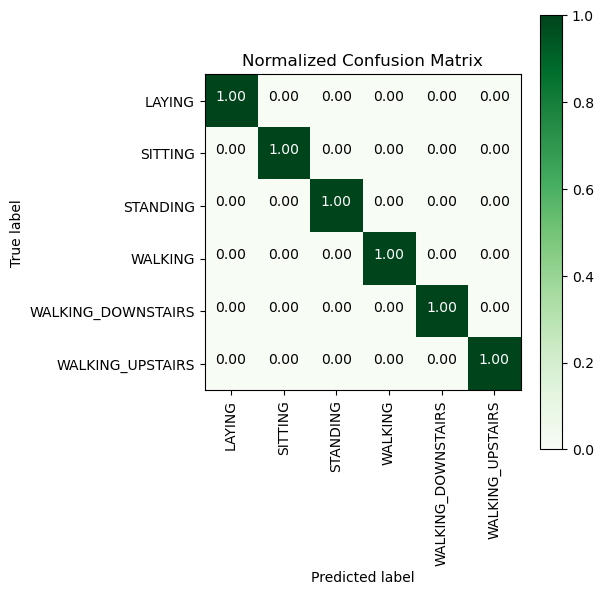

**************** Classification Report ****************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       1.00      1.00      1.00       491
           2       1.00      1.00      1.00       532
           3       1.00      1.00      1.00       496
           4       1.00      1.00      1.00       420
           5       1.00      1.00      1.00       471

    accuracy                           1.00      2947
   macro avg       1.00      1.00      1.00      2947
weighted avg       1.00      1.00      1.00      2947


F1 Score: 0.9996606831210677

Precision: 0.9996613546224753

Recall: 0.999660671869698

ROC AUC: 0.999796001631987


==> Best Estimator:
	DecisionTreeClassifier(max_depth=5)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 5}

==> No. of CrossValidation sets:
	Total numbre of cross validation sets: 5

==> Best Score:
	Average Cross Validate scores of best estimator : 0.99932000

In [55]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit LabelEncoder on target labels and transform them to numeric values
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the parameters grid for the Decision Tree Classifier
parameters = {'max_depth': np.arange(3, 10, 2)}

# Initialize a Decision Tree Classifier
dt = DecisionTreeClassifier()

# Create a GridSearchCV object with the Decision Tree Classifier and parameters grid
dt_grid = GridSearchCV(dt, param_grid=parameters, n_jobs=-1)

# Train and evaluate the Decision Tree Classifier using the perform_model function
dt_grid_results = perform_model(dt_grid, X_train, y_train_encoded, X_test, y_test_encoded, class_labels=labels)


# Print attributes of the best model found by the grid search
print_grid_search_attributes(dt_grid_results['model'])


Training the model..
==> Training time: 0:03:59.184093
Predicting test data
==> Testing time: 0:00:00.024297
==> Accuracy: 0.9704784526637258

 ******** Confusion Matrix ********

 [[537   0   0   0   0   0]
 [  0 469  22   0   0   0]
 [  0  11 521   0   0   0]
 [  0   0   0 492   4   0]
 [  0   0   0   8 380  32]
 [  0   0   0   6   4 461]]


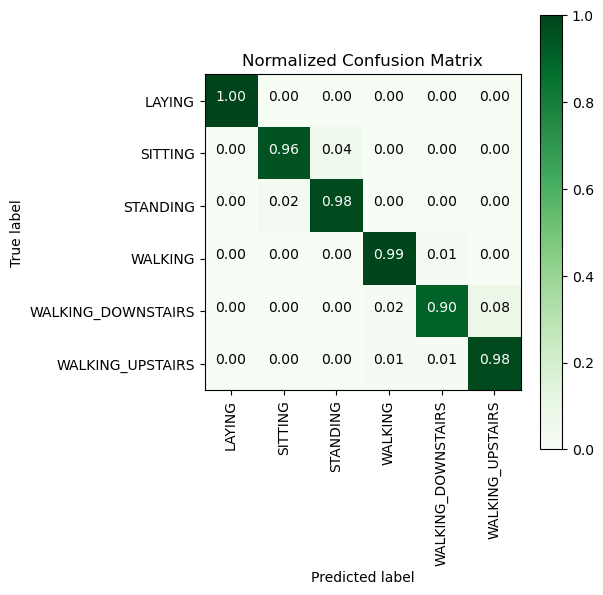

**************** Classification Report ****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       0.98      0.96      0.97       491
          STANDING       0.96      0.98      0.97       532
           WALKING       0.97      0.99      0.98       496
WALKING_DOWNSTAIRS       0.98      0.90      0.94       420
  WALKING_UPSTAIRS       0.94      0.98      0.96       471

          accuracy                           0.97      2947
         macro avg       0.97      0.97      0.97      2947
      weighted avg       0.97      0.97      0.97      2947


F1 Score: 0.970342889355549

Precision: 0.9708986992779333

Recall: 0.9704784526637258

ROC AUC: 0.9992982069362192


==> Best Estimator:
	RandomForestClassifier(max_depth=11, n_estimators=150)


==> Best parameters:
	Parameters of best estimator : {'max_depth': 11, 'n_estimators': 150}

==> No. of CrossValidation sets:
	Total numbre of c

In [56]:
# Define the parameters grid for the Random Forest Classifier
params = {'n_estimators': np.arange(10, 201, 20), 'max_depth': np.arange(3, 15, 2)}

# Initialize a Random Forest Classifier
rfc = RandomForestClassifier()

# Create a GridSearchCV object with the Random Forest Classifier and parameters grid
rfc_grid = GridSearchCV(rfc, param_grid=params, n_jobs=-1)

# Train and evaluate the Random Forest Classifier using the perform_model function
rfc_grid_results = perform_model(rfc_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# Print attributes of the best model found by the grid search
print_grid_search_attributes(rfc_grid_results['model'])


Training the model..


/Users/ashikamohanm/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


==> Training time: 0:02:39.698384
Predicting test data
==> Testing time: 0:00:00.009585
==> Accuracy: 0.9928741092636579

 ******** Confusion Matrix ********

 [[537   0   0   0   0   0]
 [  1 488   2   0   0   0]
 [  0   0 531   1   0   0]
 [  0   0   0 494   2   0]
 [  0   0   0   5 406   9]
 [  0   0   1   0   0 470]]


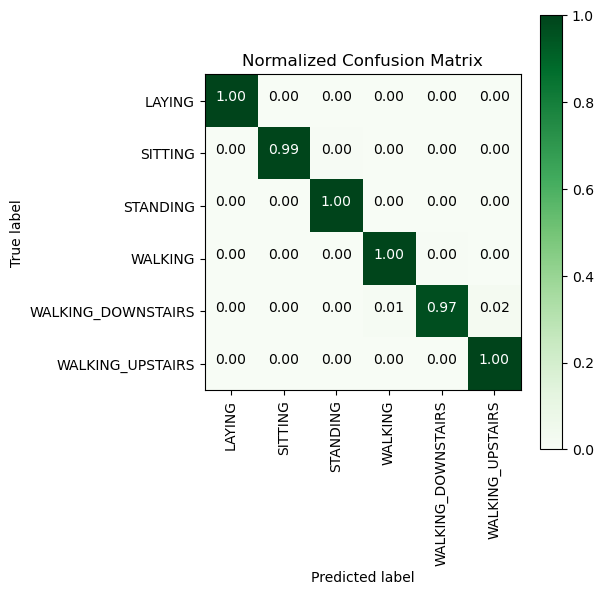

**************** Classification Report ****************
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       537
           SITTING       1.00      0.99      1.00       491
          STANDING       0.99      1.00      1.00       532
           WALKING       0.99      1.00      0.99       496
WALKING_DOWNSTAIRS       1.00      0.97      0.98       420
  WALKING_UPSTAIRS       0.98      1.00      0.99       471

          accuracy                           0.99      2947
         macro avg       0.99      0.99      0.99      2947
      weighted avg       0.99      0.99      0.99      2947


F1 Score: 0.9928543767986517

Precision: 0.9929258854136765

Recall: 0.9928741092636579

ROC AUC: 0.9999742516903969
Best parameters found by grid search: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'adam'}


In [57]:
# Define the parameters for the grid search
params = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],  # Specify different hidden layer sizes
    'activation': ['relu', 'tanh'],  # Activation functions to try
    'solver': ['adam'],  # Optimizer algorithm
    'alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
}

# Create an instance of the ANN model
ann = MLPClassifier()

# Create a grid search object
ann_grid = GridSearchCV(ann, param_grid=params, n_jobs=-1)

# Perform model evaluation
ann_grid_results = perform_model(ann_grid, X_train, y_train, X_test, y_test, class_labels=labels)

# To observe the attributes of the best ANN model found by the grid search
print("Best parameters found by grid search:", ann_grid_results['model'].best_params_)



In [58]:
# Print the F1 scores, accuracy, and error
print('\n                            Accuracy      Error         F1 Score   Precision    Recall      ROC AUC')
print('                           ----------    --------     -----------  ----------  ----------  ----------')
print('Decision Tree             : {:.4f}%      {:.4f}%       {:.4f}        {:.4f}      {:.4f}      {:.4f}'.format(
    dt_grid_results['accuracy'] * 100, 100 - (dt_grid_results['accuracy'] * 100), dt_grid_results['f1_score'],
    dt_grid_results['precision'], dt_grid_results['recall'], dt_grid_results['roc_auc']))
print('Random Forest             : {:.4f}%      {:.4f}%       {:.4f}        {:.4f}      {:.4f}      {:.4f}'.format(
    rfc_grid_results['accuracy'] * 100, 100 - (rfc_grid_results['accuracy'] * 100), rfc_grid_results['f1_score'],
    rfc_grid_results['precision'], rfc_grid_results['recall'], rfc_grid_results['roc_auc']))
print('Artificial Neural Network : {:.4f}%      {:.4f}%       {:.4f}        {:.4f}      {:.4f}      {:.4f}'.format(
    ann_grid_results['accuracy'] * 100, 100 - (ann_grid_results['accuracy'] * 100), ann_grid_results['f1_score'],
    ann_grid_results['precision'], ann_grid_results['recall'], ann_grid_results['roc_auc']))



                            Accuracy      Error         F1 Score   Precision    Recall      ROC AUC
                           ----------    --------     -----------  ----------  ----------  ----------
Decision Tree             : 99.9661%      0.0339%       0.9997        0.9997      0.9997      0.9998
Random Forest             : 97.0478%      2.9522%       0.9703        0.9709      0.9705      0.9993
Artificial Neural Network : 99.2874%      0.7126%       0.9929        0.9929      0.9929      1.0000


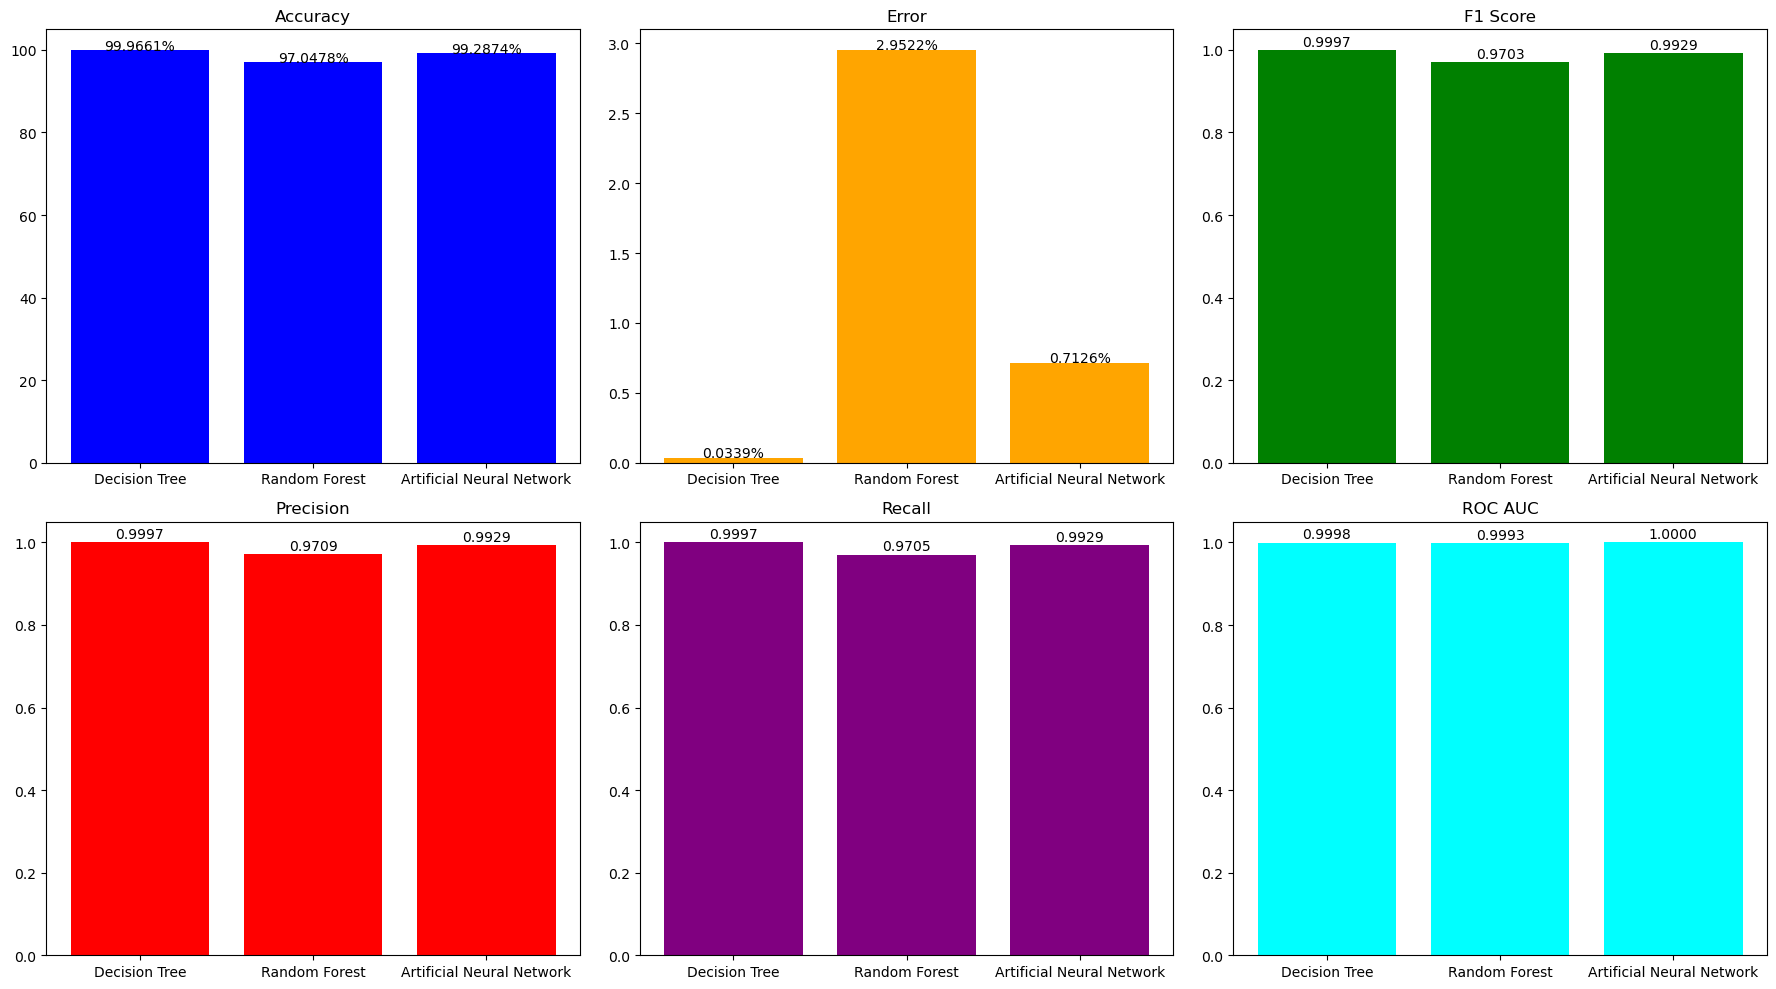

In [60]:
# Data
models = ['Decision Tree', 'Random Forest', 'Artificial Neural Network']
accuracy = [dt_grid_results['accuracy']*100, rfc_grid_results['accuracy']*100, ann_grid_results['accuracy']*100]
error = [100 - (dt_grid_results['accuracy'] * 100), 100 - (rfc_grid_results['accuracy'] * 100), 100 - (ann_grid_results['accuracy'] * 100)]
f1_score = [dt_grid_results['f1_score'], rfc_grid_results['f1_score'], ann_grid_results['f1_score']]
precision = [dt_grid_results['precision'], rfc_grid_results['precision'], ann_grid_results['precision']]
recall = [dt_grid_results['recall'], rfc_grid_results['recall'], ann_grid_results['recall']]
roc_auc = [dt_grid_results['roc_auc'], rfc_grid_results['roc_auc'], ann_grid_results['roc_auc']]

# Create subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# Plot Accuracy
axs[0, 0].bar(models, accuracy, color='blue')
axs[0, 0].set_title('Accuracy')
for i, v in enumerate(accuracy):
    axs[0, 0].text(i, v + 0.01, "{:.4f}%".format(v), ha='center')

# Plot Error
axs[0, 1].bar(models, error, color='orange')
axs[0, 1].set_title('Error')
for i, v in enumerate(error):
    axs[0, 1].text(i, v + 0.01, "{:.4f}%".format(v), ha='center')

# Plot F1 Score
axs[0, 2].bar(models, f1_score, color='green')
axs[0, 2].set_title('F1 Score')
for i, v in enumerate(f1_score):
    axs[0, 2].text(i, v + 0.01, "{:.4f}".format(v), ha='center')

# Plot Precision
axs[1, 0].bar(models, precision, color='red')
axs[1, 0].set_title('Precision')
for i, v in enumerate(precision):
    axs[1, 0].text(i, v + 0.01, "{:.4f}".format(v), ha='center')

# Plot Recall
axs[1, 1].bar(models, recall, color='purple')
axs[1, 1].set_title('Recall')
for i, v in enumerate(recall):
    axs[1, 1].text(i, v + 0.01, "{:.4f}".format(v), ha='center')

# Plot ROC AUC
axs[1, 2].bar(models, roc_auc, color='cyan')
axs[1, 2].set_title('ROC AUC')
for i, v in enumerate(roc_auc):
    axs[1, 2].text(i, v + 0.01, "{:.4f}".format(v), ha='center')

plt.tight_layout()
plt.show()
